In [99]:
%pip install pandas
%pip install matplotlib
%pip install openpyxl
%pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [100]:
# Carregar dados
df = pd.read_csv("ProcessoSeletivo.csv")

print(f'Há {len(df)} linhas de informação neste banco')

Há 3000 linhas de informação neste banco


# DISTRIBUIÇÃO DOS DADOS

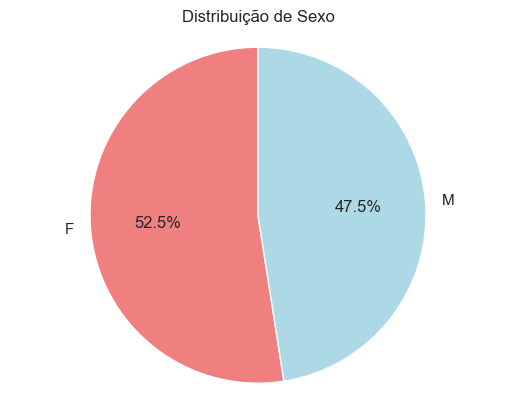

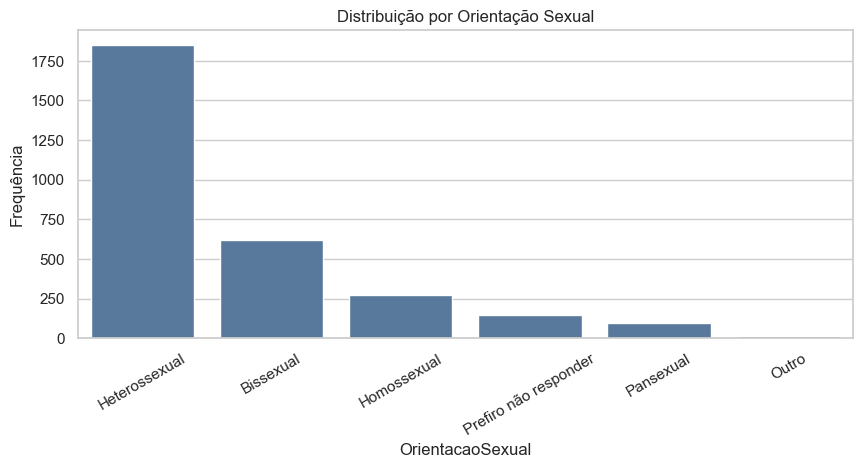

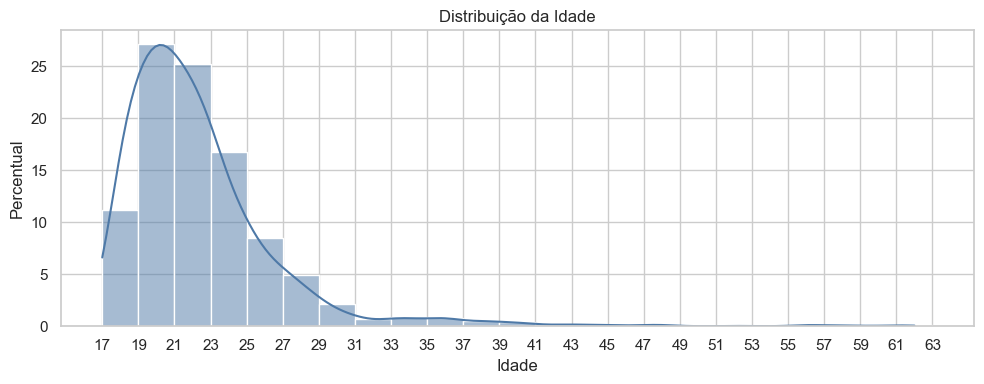

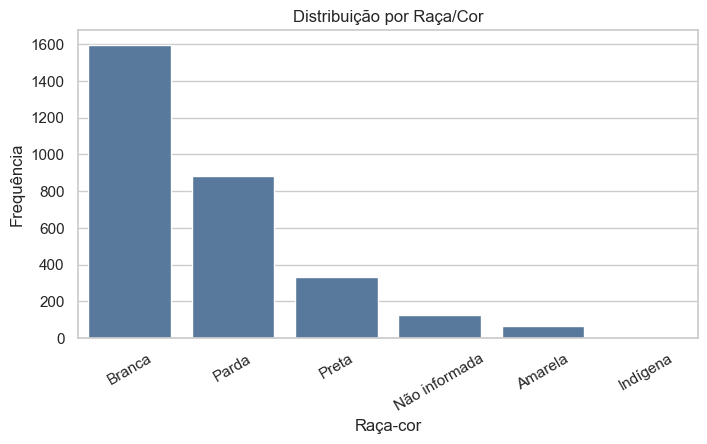

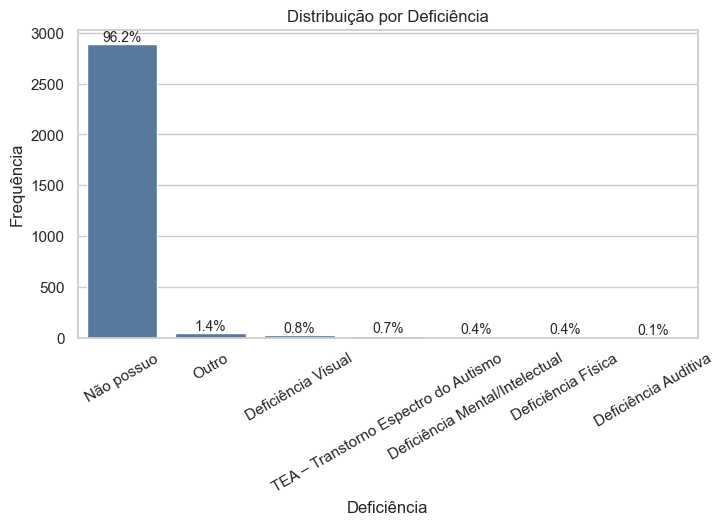

In [101]:
# SEXO
labels = df['Sexo'].value_counts().index
sizes = df['Sexo'].value_counts().values
cores = ['lightblue' if label=='M' else 'lightcoral' for label in labels]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=cores)
plt.title("Distribuição de Sexo")
plt.axis('equal') 
plt.show()


# ORIENTACAO SEXUAL
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="OrientacaoSexual", order=df["OrientacaoSexual"].value_counts().index, color='#4E79A7')
plt.title("Distribuição por Orientação Sexual")
plt.ylabel("Frequência")
plt.xticks(rotation=30)
plt.show()


# IDADE
idade_min = df['Idade'].min()
idade_max = df['Idade'].max()
bins_idade = np.arange(idade_min, idade_max + 2, 2)

plt.figure(figsize=(10,4))
sns.histplot(df['Idade'], bins=bins_idade, kde=True, color='#4E79A7', stat="percent")
plt.title("Distribuição da Idade")
plt.xlabel("Idade")
plt.ylabel("Percentual")
plt.xticks(bins_idade)
plt.tight_layout()
plt.show() 


# RAÇA/COR
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Raça-cor", order=df["Raça-cor"].value_counts().index, color='#4E79A7')
plt.title("Distribuição por Raça/Cor")
plt.ylabel("Frequência")
plt.xticks(rotation=30)
plt.show()


# 5. Deficiência
plt.figure(figsize=(8,4))
ax = sns.countplot(data=df, x="Deficiência", order=df["Deficiência"].value_counts().index, color='#4E79A7')
plt.title("Distribuição por Deficiência")
plt.ylabel("Frequência")
plt.xticks(rotation=30)

total = len(df)
for p in ax.patches:
    height = p.get_height()
    percent = 100 * height / total
    ax.text(p.get_x() + p.get_width()/2, height + 0.5, f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

# ANÁLISE DESCRITIVA

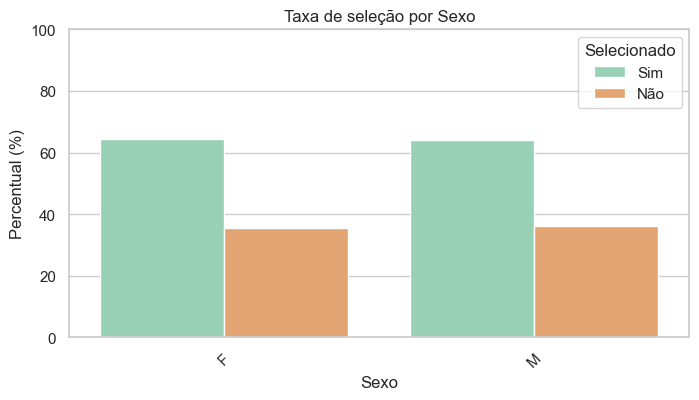

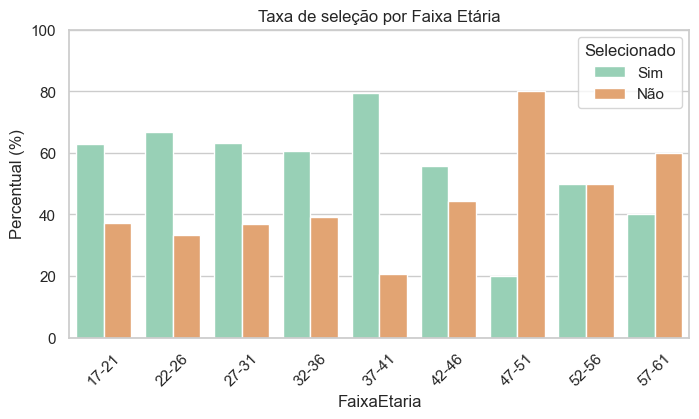

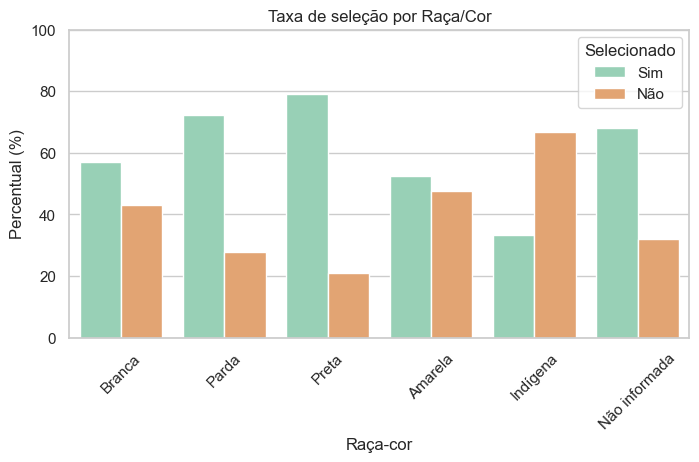

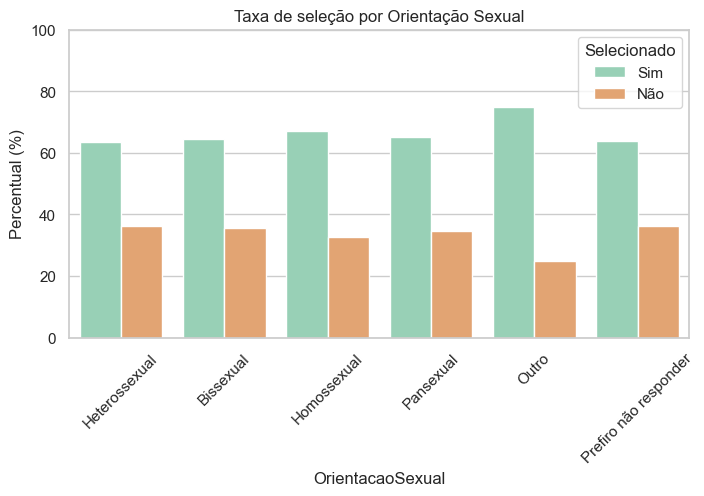

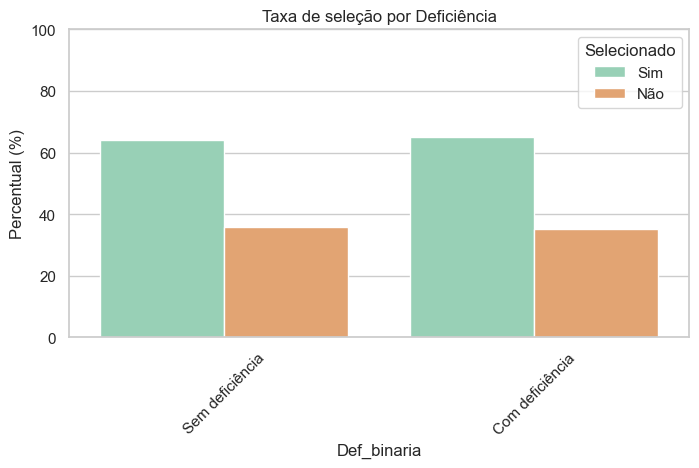

In [ ]:
sns.set(style="whitegrid")

# Função para calcular taxa relativa dentro de cada grupo, garantindo todas as categorias
def taxa_selecao_dupla(df, coluna, categorias=None):
    tab = pd.crosstab(df[coluna], df['Selecionado'], normalize='index') * 100
    if categorias is not None:
        tab = tab.reindex(categorias) 
    return tab.reset_index()

# Função para plotar gráfico de barras lado a lado
def plot_taxa(df_taxa, coluna, titulo):
    df_long = df_taxa.melt(id_vars=coluna, value_vars=['Sim','Não'], 
                           var_name='Selecionado', value_name='Percentual')
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_long, x=coluna, y='Percentual', hue='Selecionado', palette=['#8fd9b6','#f4a261'])
    plt.title(titulo)
    plt.ylabel("Percentual (%)")
    plt.ylim(0,100)
    plt.xticks(rotation=45)
    plt.show()


# 1. Sexo
taxa_sexo = taxa_selecao_dupla(df, 'Sexo', categorias=['F','M'])
plot_taxa(taxa_sexo, 'Sexo', "Taxa de seleção por Sexo")


# 2. Faixas etárias
bins = range(df['Idade'].min(), df['Idade'].max()+5, 5)
labels = [f'{b}-{b+4}' for b in bins[:-1]]
df['FaixaEtaria'] = pd.cut(df['Idade'], bins=bins, labels=labels, right=False)
taxa_idade = taxa_selecao_dupla(df, 'FaixaEtaria', categorias=labels)
plot_taxa(taxa_idade, 'FaixaEtaria', "Taxa de seleção por Faixa Etária")


# 3. Raça/Cor
categorias_raca = ['Branca', 'Parda', 'Preta', 'Amarela', 'Indígena', 'Não informada']
taxa_raca = taxa_selecao_dupla(df, 'Raça-cor', categorias=categorias_raca)
plot_taxa(taxa_raca, 'Raça-cor', "Taxa de seleção por Raça/Cor")


# 4. Orientação Sexual
categorias_orient = ['Heterossexual','Bissexual','Homossexual','Pansexual','Outro','Prefiro não responder']
taxa_ori = taxa_selecao_dupla(df, 'OrientacaoSexual', categorias=categorias_orient)
plot_taxa(taxa_ori, 'OrientacaoSexual', "Taxa de seleção por Orientação Sexual")


# 5. Deficiência
df['Def_binaria'] = df['Deficiência'].apply(lambda x: 'Sem deficiência' if x=='Não possuo' else 'Com deficiência')
df['Def_binaria'] = pd.Categorical(df['Def_binaria'], categories=['Sem deficiência','Com deficiência'])
taxa_def = taxa_selecao_dupla(df, 'Def_binaria', categorias=['Sem deficiência','Com deficiência'])
plot_taxa(taxa_def, 'Def_binaria', "Taxa de seleção por Deficiência")


# Análise Inferencial - Testes de associação: Qui-Quadrado

In [105]:
def testar_associacao(df, var_categorica, target="Selecionado"):
    tabela = pd.crosstab(df[var_categorica], df[target])
    qui2, p_qui2, dof, expected = chi2_contingency(tabela)

    print(f"\n*** Variável: {var_categorica}")
    print("Tabela de contingência:")
    print(tabela)
    print(f"\nQui-quadrado = {qui2:.4f}")
    print(f"Graus de liberdade = {dof}")
    print(f"p-valor (Qui2) = {p_qui2:.4f}")

# Rodar para várias variáveis
for var in ["Sexo", "OrientacaoSexual", "Raça-cor", "Deficiência", "FaixaEtaria"]:
    testar_associacao(df, var)


*** Variável: Sexo
Tabela de contingência:
Selecionado  Não   Sim
Sexo                  
F            559  1015
M            514   912

Qui-quadrado = 0.0699
Graus de liberdade = 1
p-valor (Qui2) = 0.7914

*** Variável: OrientacaoSexual
Tabela de contingência:
Selecionado            Não   Sim
OrientacaoSexual                
Bissexual              220   400
Heterossexual          674  1177
Homossexual             90   184
Outro                    4    12
Pansexual               33    62
Prefiro não responder   52    92

Qui-quadrado = 2.2334
Graus de liberdade = 5
p-valor (Qui2) = 0.8160

*** Variável: Raça-cor
Tabela de contingência:
Selecionado    Não  Sim
Raça-cor               
Amarela         30   33
Branca         687  909
Indígena         2    1
Não informada   40   85
Parda          244  636
Preta           70  263

Qui-quadrado = 98.9457
Graus de liberdade = 5
p-valor (Qui2) = 0.0000

*** Variável: Deficiência
Tabela de contingência:
Selecionado                            Não